## dir setup

In [1]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [2]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
interim_data_dir = os.path.join(project_dir, os.environ.get("INTERIM_DATA_DIR"))
wordvecs_data_dir = os.path.join(project_dir, os.environ.get("WORDVECS_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

In [3]:
# import numpy as np
# from datetime import datetime

In [4]:
import pandas as pd
# pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# from tqdm import tqdm
# tqdm.pandas()

In [7]:
import sys
sys.path.insert(0, '..')

In [8]:
from src.features import *

### functions

In [75]:
def get_trace(df, seq_sel = None):
    """None means all seqs are selected"""
    if seq_sel is None:
        trace = df.copy()
    else:
        trace = df[df.seq.isin(seq_sel)].copy()
    
    unique_viewed_items = trace.query("event_type == 'view'").groupby('seq').event_info.unique()
    unique_viewed_items = unique_viewed_items.str.len()
    unique_viewed_items.name = 'unique_items'
    
    trace = trace.query("event_type != 'buy'")
    trace = trace.groupby('seq').event_type.value_counts().unstack().fillna(0).astype(int)
    trace = pd.concat([trace, unique_viewed_items], axis = 1)
    
    trace = trace.fillna(0)
    trace = trace.astype(int)
    
    return trace

### checking validations

In [10]:
from pathlib import Path
fns = sorted(Path(cv_dir).iterdir(), key=os.path.getmtime)
fns

[PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_128__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_256__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_384__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_512__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_768__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../repor

In [11]:
# fns = os.listdir(cv_dir, )
# fns

In [12]:
fn = 'pred__alpha_val_200__buy_weight_200__factors_768__iterations_15__regularization_0.01.csv'
pred = pd.read_csv(os.path.join(cv_dir, fn), index_col = 0)

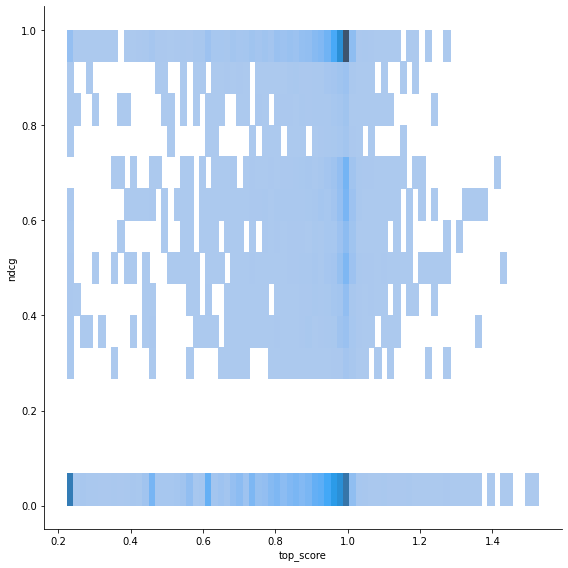

In [13]:
sns.displot(data = pred, x = 'top_score', y = 'ndcg', height = 8, );

<AxesSubplot:xlabel='top_score', ylabel='ndcg'>

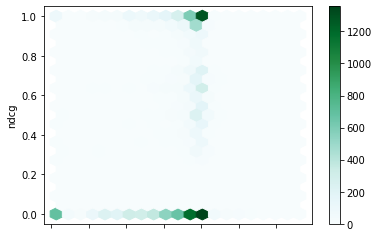

In [14]:
pred.plot.hexbin(x = 'top_score', y = 'ndcg', gridsize = 20)

In [15]:
pred['ndcg_cut'] = pd.cut(pred.ndcg, bins = np.arange(0, 1.11, 0.1), right = False)
pred['top_score_cut'] = pd.cut(pred.top_score, bins = np.arange(0, 2.01, 0.1), right = False)

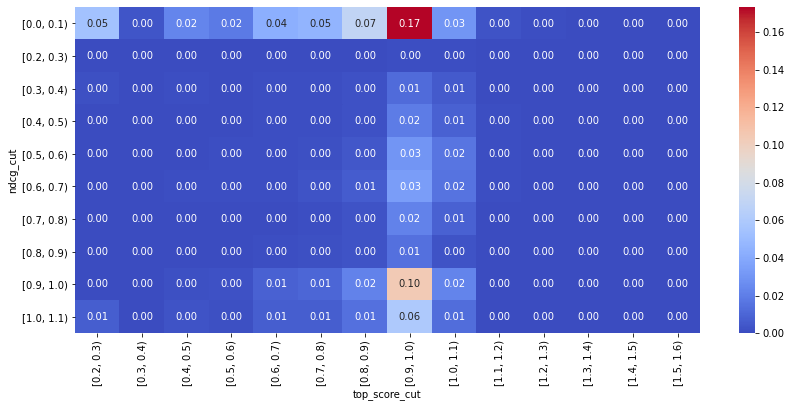

In [16]:
t = pd.crosstab(index = pred.ndcg_cut, columns = pred.top_score_cut)
plt.figure(figsize = (14, 6))
sns.heatmap((t/t.sum().sum()), cmap = 'coolwarm', annot = True, fmt='.2f');

In [17]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'
train, test = read_processed(train_fn, test_fn)

lang both


In [18]:
preds_0 = pred[pred.ndcg == 0]

train.event_type = train.event_type.fillna('buy')

train_e = train.groupby('seq').event_type.value_counts().unstack().reset_index()

pred = pd.merge(pred, train_e, how = 'left')

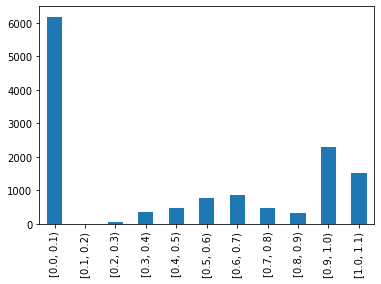

In [19]:
pred.ndcg_cut.value_counts().sort_index().plot(kind = 'bar');

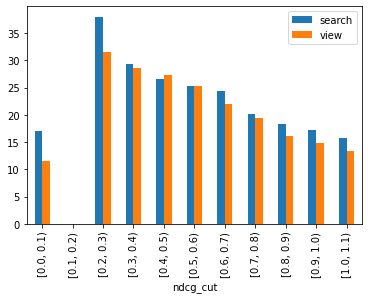

In [20]:
pred.groupby('ndcg_cut')[['search', 'view']].mean().plot(kind = 'bar');

<AxesSubplot:xlabel='top_score_cut'>

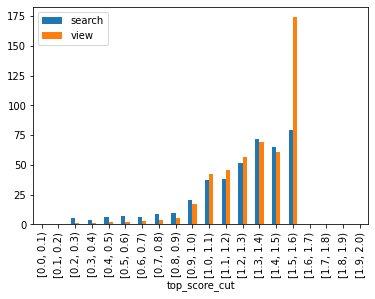

In [21]:
pred.groupby('top_score_cut')[['search', 'view']].mean().plot(kind = 'bar')

In [22]:
zero_ndcg = pd.Interval(0.0, 0.1, closed = 'left')
zero_topscore = pd.Interval(0.0, 0.1, closed = 'left')

In [23]:
pred['both_zeros'] = (pred.ndcg_cut == zero_ndcg) & (pred.top_score_cut == zero_topscore)
pred['ndcg_zero'] = (pred.ndcg_cut == zero_ndcg) 
pred['topscore_zero'] = (pred.top_score_cut == zero_topscore)

In [24]:
pred.search = pred.search.fillna(0)

(0.0, 100.0)

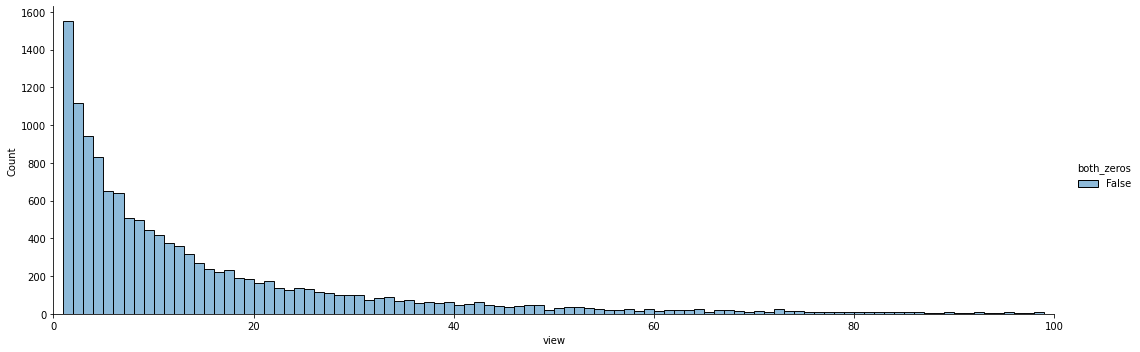

In [25]:
sns.displot(pred, x="view", hue="both_zeros", aspect = 3, bins = range(100))
plt.xlim(0, 100)

(0.0, 100.0)

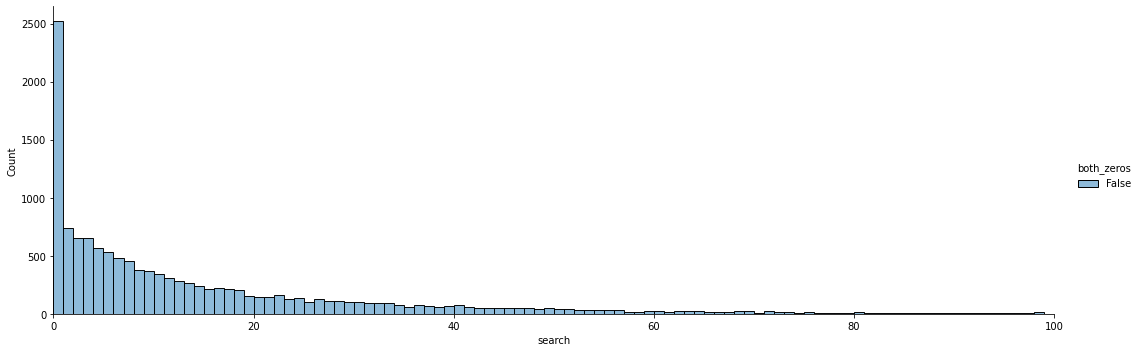

In [26]:
sns.displot(pred, x="search", hue="both_zeros", aspect = 3, bins = range(100))
plt.xlim(0, 100)

#### 11% of the seqs had only 1 view
and 8% had 2 views

In [27]:
pred.view.value_counts(normalize = True)

1.0      0.117110
2.0      0.084189
3.0      0.071202
4.0      0.062745
5.0      0.049003
           ...   
205.0    0.000076
141.0    0.000076
160.0    0.000076
118.0    0.000076
167.0    0.000076
Name: view, Length: 149, dtype: float64

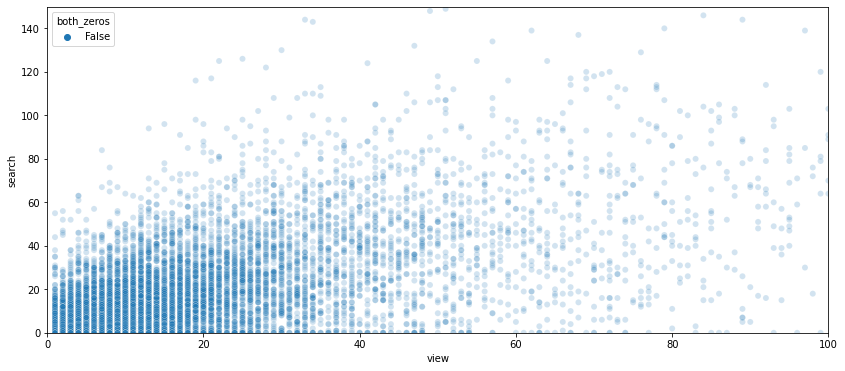

In [28]:
plt.figure(figsize = (14, 6))
plt.xlim(0, 100)
plt.ylim(0, 150)
sns.scatterplot(data=pred, x="view", y="search", hue="both_zeros", alpha = 0.2, );

<Figure size 1008x432 with 0 Axes>

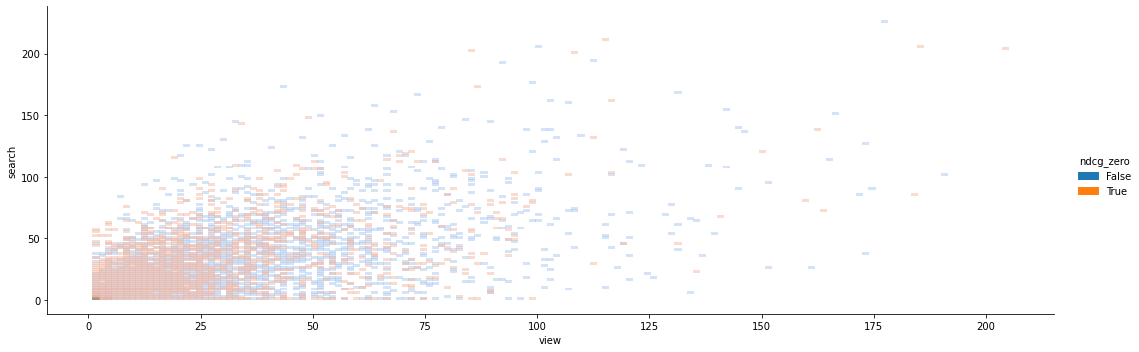

In [29]:
plt.figure(figsize = (14, 6))
# plt.xlim(0, 100)
# plt.ylim(0, 150)
sns.displot(data=pred, x="view", y="search", hue="ndcg_zero", alpha = 0.5, aspect = 3 );

<Figure size 1008x432 with 0 Axes>

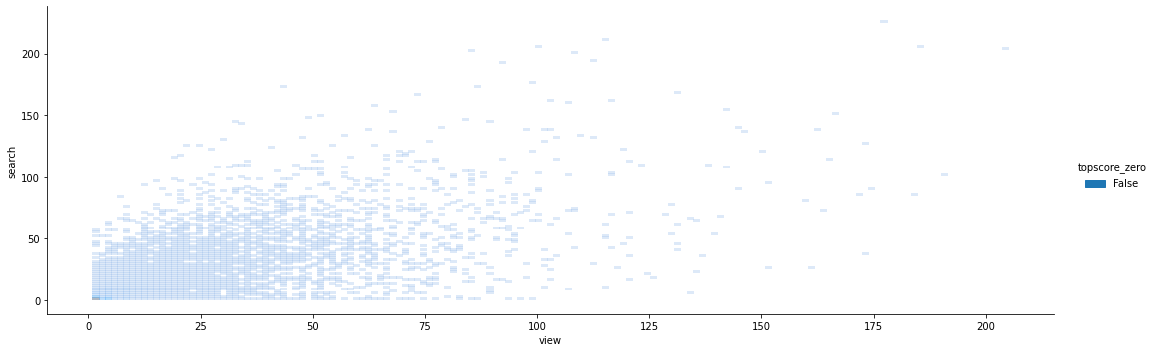

In [30]:
plt.figure(figsize = (14, 6))
# plt.xlim(0, 100)
# plt.ylim(0, 150)
sns.displot(data=pred, x="view", y="search", hue="topscore_zero", alpha = 0.4, aspect = 3);

### item_data

In [31]:
item_data_fn = 'item_data.pkl'
item_data_fp = os.path.join(processed_data_dir, item_data_fn)
item_data = pd.read_pickle(item_data_fp)

In [32]:
item_data

,item_id,title,domain_id,product_id,price,category_id,condition,title_lower,lang_domain,title_embs
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new,casa sola en venta con gran patio solo pago de...,es,"[-0.1664, -0.03888, 0.03452, 0.0887, 0.0623, 0..."
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new,resident evil origins collection nintendo swit...,es,"[0.0116, -0.02869, -0.0703, 0.3406, 0.1633, -0..."
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,NaN,350.00,MLM7697,new,falda de imitación piel negra,es,"[-0.1075, 0.2355, 0.01142, 0.0687, 0.09735, 0...."
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,NaN,3200.00,MLM9761,used,powercolor red devil radeon rx 580 8gb gddr5,es,"[0.1323, 0.001538, -0.2064, 0.4216, 0.1107, -0..."
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,NaN,1599.00,MLM1652,used,laptop hp nx6320 core duo con puerto db9 windo...,es,"[0.185, -0.008896, -0.2537, 0.391, 0.1273, -0...."
...,...,...,...,...,...,...,...,...,...,...
2102272,1099649,Carrinho De Bebê Stoke,MLB-BABY_STROLLERS,NaN,1600.00,MLB1386,used,carrinho de bebê stoke,pt,"[0.2024, 0.2474, 0.10767, -0.217, -0.2332, -0...."
2102273,1482187,Grelha Para Hambúrguer Preta Com Cabo Em Madei...,MLB-KITCHEN_SUPPLIES,NaN,69.90,MLB193425,new,grelha para hambúrguer preta com cabo em madei...,pt,"[-0.215, -0.01633, 0.10004, -0.205, 0.0761, -0..."
2102274,1118904,Meia Tam 7/8 Anti Embolia Trombose Antitrombo,MLB-SOCKS,NaN,118.00,MLB108791,new,meia tam 7/8 anti embolia trombose antitrombo,pt,"[-0.0987, 0.0804, -0.1415, -0.1965, -0.258, -0..."
2102275,237229,Pano De Boca Cremer Menina Luxo Bordado C/3 Und,MLB-DISPOSABLE_BABY_DIAPERS,NaN,26.90,MLB40629,new,pano de boca cremer menina luxo bordado c/3 und,pt,"[-0.03394, 0.04376, 0.0742, -0.02483, -0.05072..."


In [33]:
pred_seqs = pred.seq.values
trace = get_trace(train, seq_sel = pred_seqs)

In [34]:
views = train[train.seq.isin(pred_seqs)]
views = views.query("event_type == 'view'")

In [35]:
views = pd.merge(views, item_data[['item_id', 'price', 'condition', 'lang_domain']], 
                 left_on = 'event_info', right_on = 'item_id', 
                 how = 'left')

In [36]:
views

,seq,item_bought,event_info,event_timestamp,event_type,time_diff,lang_seq,in_nav,in_nav_pred,item_id,price,condition,lang_domain
0,369666,806961,1597049,2019-10-08 10:54:03,view,NaN,pt,False,0.127035,1597049,23.90,new,pt
1,24939,843741,1899338,2019-10-24 15:50:44,view,NaN,pt,False,0.127035,1899338,609.49,new,pt
2,82157,522343,1944054,2019-10-05 18:20:32,view,NaN,pt,False,0.127035,1944054,27.90,new,pt
3,369498,247706,655199,2019-10-29 05:49:24,view,NaN,pt,False,0.127035,655199,239.00,new,pt
4,82298,215513,971034,2019-10-16 02:19:42,view,NaN,pt,False,0.127035,971034,403.84,new,pt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201371,263528,1791906,203137,2019-10-09 05:45:42,view,25.0,pt,False,0.356841,203137,11800.00,used,pt
201372,263528,1791906,1976783,2019-10-09 05:45:55,view,10.0,pt,False,0.356841,1976783,12000.00,used,pt
201373,263528,1791906,1976783,2019-10-09 05:46:24,view,29.0,pt,False,0.356841,1976783,12000.00,used,pt
201374,263528,1791906,897590,2019-10-09 05:47:17,view,25.0,pt,False,0.356841,897590,15900.00,used,pt


In [37]:
agg_dict = {'price': 'mean', 
            'condition': lambda x: (x == 'new').mean(), 
            'lang_domain': lambda x: (x == 'pt').mean()} # how to get the first element?

In [38]:
views = views.groupby('seq').agg(agg_dict)

In [39]:
views

,price,condition,lang_domain
seq,,,
19,16061.925385,0.692308,1.0
44,2009.240244,0.902439,1.0
171,144.393333,1.000000,1.0
177,69.950000,1.000000,1.0
185,392.350513,1.000000,1.0
...,...,...,...
413002,313.171818,1.000000,1.0
413025,93.195714,1.000000,1.0
413029,1676.046170,1.000000,1.0


In [40]:
trace = pd.concat([trace, views], axis = 1)

In [41]:
trace

,search,view,price,condition,lang_domain
seq,,,,,
19,9,13,16061.925385,0.692308,1.0
44,31,41,2009.240244,0.902439,1.0
171,2,3,144.393333,1.000000,1.0
177,2,4,69.950000,1.000000,1.0
185,80,39,392.350513,1.000000,1.0
...,...,...,...,...,...
413002,0,11,313.171818,1.000000,1.0
413025,25,21,93.195714,1.000000,1.0
413029,24,47,1676.046170,1.000000,1.0


In [42]:
trace.price = trace.price.fillna(trace.price.mean())

### seq features 
to improve ndcg model prediction

In [43]:
X = trace[['search', 'view', 'unique_items']]
y = pred[['seq', 'ndcg']].set_index('seq')
y = y.ndcg == 0 # classification problem

In [44]:
X

,search,view
seq,,
19,9,13
44,31,41
171,2,3
177,2,4
185,80,39
...,...,...
413002,0,11
413025,25,21
413029,24,47


### model to predict ndcg

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [46]:
# rf = RandomForestClassifier()

# param_grid = {'n_estimators': [50, 100, 200, 500], 
#               'max_depth': [3, 5, 7, 9], 
#               'min_samples_split': [0.1, 0.03, 0.01, 0.003]}

# gs = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = 1, n_jobs = 4)

# gs.fit(X, y)

# print(gs.best_estimator_)
# print(gs.best_score_)

In [47]:
gs = RandomForestClassifier(max_depth=5, min_samples_split=0.01, n_estimators=200)
gs.fit(X, y)

RandomForestClassifier(max_depth=5, min_samples_split=0.01, n_estimators=200)

#### Viz predictions

In [48]:
X = [(s, v) for s in range(100) for v in range(100)]
X = pd.DataFrame(X)
X['ndcg_pred'] = gs.predict_proba(X)[:, 1]
X.columns = ['search', 'view', 'ndcg_pred']

In [49]:
X['zero_ndcg_prob_gt_.7'] = X.ndcg_pred > 0.7

In [50]:
X['zero_ndcg_prob_gt_.8'] = X.ndcg_pred > 0.8

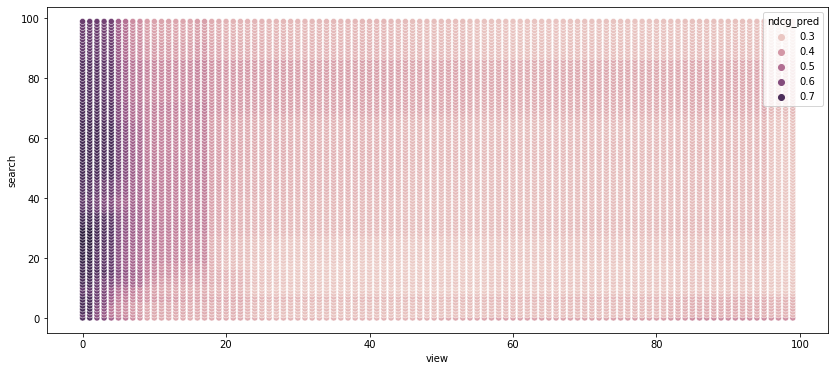

In [51]:
plt.figure(figsize = (14, 6))
sns.scatterplot(data=X, x="view", y="search", hue="ndcg_pred" );

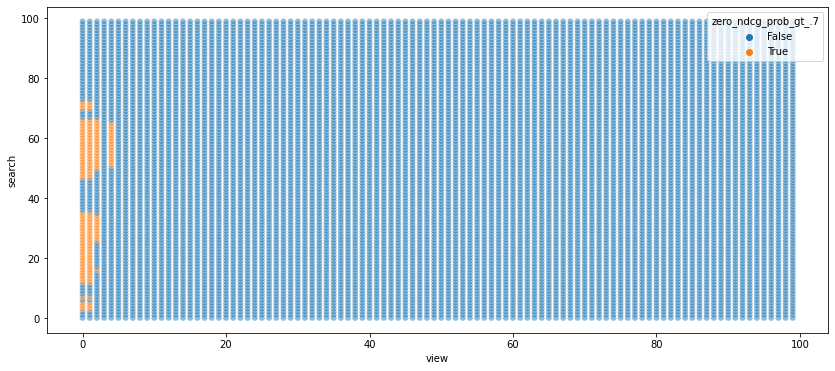

In [52]:
plt.figure(figsize = (14, 6))
sns.scatterplot(data=X, x="view", y="search", hue="zero_ndcg_prob_gt_.7" , alpha = 0.5);

### generate test seq ids with low ndcg expectation

In [59]:
test_fn = 'test_dataset.pkl'
test_fp = os.path.join(processed_data_dir, test_fn)
test = pd.read_pickle(test_fp)

In [76]:
test_trace = get_trace(test)

In [80]:
# can add unique_items too
# test_trace['ndcg_zero_pred'] = gs.predict_proba(test_trace)[:, 1]

In [81]:
test_trace

,search,view,unique_items
seq,,,
0,22,11,3
1,8,16,7
2,4,10,10
3,1,0,0
4,62,5,1
...,...,...,...
177065,3,1,1
177066,13,9,9
177067,15,10,8


In [82]:
ndcg_zero_pred_fn = 'ndcg_zero_pred.pkl'
ndcg_zero_pred_fp = os.path.join(interim_data_dir, ndcg_zero_pred_fn)
test_trace.to_pickle(ndcg_zero_pred_fp)

In [84]:
# test_trace.ndcg_zero_pred.describe(percentiles = np.arange(0, 1.0, 0.1))